# SVM Classifier
### Importing data:

In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
violations = pd.read_pickle('data/violations.pkl')

In [3]:
violations = violations[violations.delay > 21].sample(frac = 1)
X = violations.drop([
        'latitude', 'longitude', 'date', 'restaurant_id', '*', '**', '***', 'name', 'reviews', 'rating', 'delay'
    ],1)
y = (violations['*'] + violations['**'] + violations['***'] > 0).values.astype(np.int)

### Cross-validated hyperparameter tuning:

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)

In [5]:
import warnings                         # See   https://github.com/scikit-learn/scikit-learn/issues/6370   for explanation
warnings.filterwarnings("ignore")

In [6]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

gs = GridSearchCV(
        estimator = SVC(probability = True),
        param_grid = {
            'C' : np.arange(.2, .7, .1),
            'gamma' : np.arange(.1, .6, .1)
        },
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)
clf = gs.best_estimator_
gs.best_params_

{'C': 0.40000000000000008, 'gamma': 0.20000000000000001}

### Evaluation:
* Accuracies on training and test sets
* ROC curve and its AUC
* Precision-recall curve and its AUC
* Learning curve

In [7]:
clf.score(Xtrain, ytrain), clf.score(scaler.transform(Xtest), ytest)

(0.86195804195804193, 0.85682326621923932)

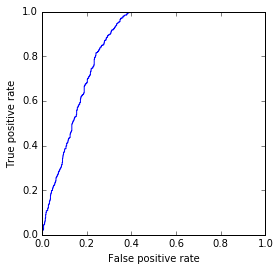

0.84829637751786879

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
plt.rcParams['figure.figsize'] = (4, 4)
xroc, yroc, _ = roc_curve(ytest, clf.predict_proba(scaler.transform(Xtest))[:,1])
plt.plot(xroc, yroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
auc(xroc,yroc)

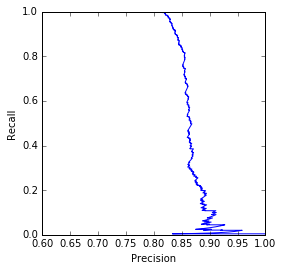

0.86558472239081685

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
xprc, yprc, _ = precision_recall_curve(ytest, clf.predict_proba(scaler.transform(Xtest))[:,1])
plt.plot(xprc, yprc)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()
average_precision_score(ytest, clf.predict_proba(scaler.transform(Xtest))[:,1])

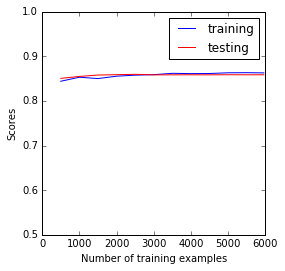

In [11]:
from sklearn.learning_curve import learning_curve
train_size, train_score, test_score = learning_curve(
    clf, 
    scaler.transform(X), 
    y, 
    n_jobs = -1,
    train_sizes = np.hstack((np.arange(500, 6000, 500), 5958))
)
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5,1])
plt.xlabel('Number of training examples')
plt.ylabel('Scores')
plt.show()